In [46]:
# import
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # Example model, replace with your model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

In [47]:
# 1. Load the dataset
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [48]:
# 2. Preprocess the data
# Handle any missing values (e.g., 'bmi' if there are NaNs)
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())  # Replace NaN in 'bmi' with mean

# Encode categorical variables (gender, ever_married, Residence_type)
data['gender'] = data['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
data['ever_married'] = data['ever_married'].map({'No': 0, 'Yes': 1})
data['work_type'] = data['work_type'].map({'children': 0, 'Govt_job': 1, 'Never_worked':2,'Private':3, 'Self-employed':4,})
data['Residence_type'] = data['Residence_type'].map({'Rural': 0, 'Urban': 1})
data['smoking_status'] = data['smoking_status'].map({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})

# Use one-hot encoding for work_type and smoking_status
data = pd.get_dummies(data, columns=['work_type', 'smoking_status'], drop_first=True)

In [49]:
# 3. Define features and target; apply data augmentation
# Drop 'id' as it's just an identifier, and 'stroke' as it's the target variable
X = data.drop(['id', 'stroke'], axis=1)
y = data['stroke']

# Apply SMOTE before splitting the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
print("\nOriginal dataset shape:", Counter(y))
print("Resampled dataset shape:", Counter(y_resampled))


Original dataset shape: Counter({0: 4861, 1: 249})
Resampled dataset shape: Counter({1: 4861, 0: 4861})


In [50]:
# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [51]:
# 5. Standardize the data (if needed, depending on model choice)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
# 6. Train the model (using RandomForest as an example)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [53]:
# 7. Make predictions
y_pred = model.predict(X_test)

In [54]:
# 8. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9562982005141388
Confusion Matrix:
 [[930  45]
 [ 40 930]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       975
           1       0.95      0.96      0.96       970

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945



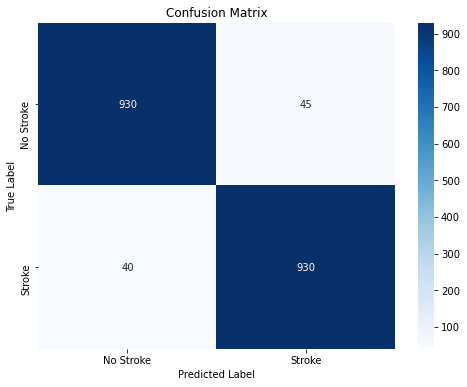


Model Performance Metrics:
Accuracy: 0.9563

Confusion Matrix Explanation:
True Negatives (top-left): 930
False Positives (top-right): 45
False Negatives (bottom-left): 40
True Positives (bottom-right): 930


In [55]:
# 9. Visualize the results
# Create confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, 
            annot=True,  # Show numbers in cells
            fmt='d',     # Format as integers
            cmap='Blues',  # Color scheme (you can change this)
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])

plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# You can also print the raw metrics for reference
print("\nModel Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix Explanation:")
print("True Negatives (top-left):", conf_matrix[0][0])
print("False Positives (top-right):", conf_matrix[0][1])
print("False Negatives (bottom-left):", conf_matrix[1][0])
print("True Positives (bottom-right):", conf_matrix[1][1])